In [1]:
# Colab Requirements
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
## Basics
import gc
gc.collect()
import warnings
warnings.filterwarnings('ignore')
import time
import numpy
import numpy as np
from PIL import Image
from operator import truediv
import scipy.io as sio
import os
import pandas as pd
import seaborn as sns
import spectral
## Ploting
from plotly.offline import init_notebook_mode
import plotly.graph_objs as go
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
init_notebook_mode(connected=True)
%matplotlib inline
## Sklearn 
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, cohen_kappa_score
from sklearn.decomposition import IncrementalPCA
## Deep Model
import keras
import h5py
from keras.layers import Dropout, Input, Conv2D, Conv3D, MaxPool3D, Flatten, Dense, Reshape, BatchNormalization
from plotly.offline import iplot, init_notebook_mode
from keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adadelta
from keras.models import Sequential, Model
from keras.utils import np_utils
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
## Mounting Colab

#drive.mount('/content/drive')

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
## Split Training, Validation and Test Sets
def SplitTr_Te(HSI, GT, TeRatio, randomState=345):
    Tr, Te, TrC, TeC = train_test_split(HSI, GT, test_size=TeRatio, random_state=randomState, stratify=GT)
    return Tr, Te, TrC, TeC

In [3]:
## Dimensional Reduction Method
def DL_Method(HSI, numComponents = 75):
    RHSI = np.reshape(HSI, (-1, HSI.shape[2]))
    n_batches = 256
    inc_pca = IncrementalPCA(n_components=numComponents)
    for X_batch in np.array_split(RHSI, n_batches):
        inc_pca.partial_fit(X_batch)
    X_ipca = inc_pca.transform(RHSI)
    RHSI = np.reshape(X_ipca, (HSI.shape[0],HSI.shape[1], numComponents))
    return RHSI

In [4]:
## Padding
def ZeroPad(HSI, margin=2):
    NHSI = np.zeros((HSI.shape[0] + 2 * margin, HSI.shape[1] + 2* margin, HSI.shape[2]))
    x_offset = margin
    y_offset = margin
    NHSI[x_offset:HSI.shape[0] + x_offset, y_offset:HSI.shape[1] + y_offset, :] = HSI
    return NHSI

In [5]:
## Spatial Patches in 3D
def HSICubes(HSI, GT, WinSize=5, removeZeroLabels = True):
    margin = int((WinSize - 1) / 2)
    zeroPaddedX = ZeroPad(HSI, margin=margin)
    # split patches
    patchesData = np.zeros((HSI.shape[0] * HSI.shape[1], WinSize, WinSize, HSI.shape[2]))
    patchesLabels = np.zeros((HSI.shape[0] * HSI.shape[1]))
    patchIndex = 0
    for r in range(margin, zeroPaddedX.shape[0] - margin):
        for c in range(margin, zeroPaddedX.shape[1] - margin):
            patch = zeroPaddedX[r - margin:r + margin + 1, c - margin:c + margin + 1]   
            patchesData[patchIndex, :, :, :] = patch
            patchesLabels[patchIndex] = GT[r-margin, c-margin]
            patchIndex = patchIndex + 1
    if removeZeroLabels:
        patchesData = patchesData[patchesLabels>0,:,:,:]
        patchesLabels = patchesLabels[patchesLabels>0]
        patchesLabels -= 1
    return patchesData, patchesLabels

In [6]:
## Compute Per Class Accuacy form Confusion Matrix
def AA_andEachClassAccuracy(confusion_matrix):
    counter = confusion_matrix.shape[0]
    list_diag = np.diag(confusion_matrix)
    list_raw_sum = np.sum(confusion_matrix, axis=1)
    each_acc = np.nan_to_num(truediv(list_diag, list_raw_sum))
    average_acc = np.mean(each_acc)
    return each_acc, average_acc

In [7]:
## Assigning Class Labels and Computing the Test Accuracy
def reports(Te,TeC):
    start = time.time()
    Y_pred = model.predict(Te)
    y_pred = np.argmax(Y_pred, axis=1)
    end = time.time()
    total = end - start
    target_names = ['Alfalfa', 'Corn-notill', 'Corn-mintill', 'Corn'
                        ,'Grass-pasture', 'Grass-trees', 'Grass-pasture-mowed', 
                        'Hay-windrowed', 'Oats', 'Soybean-notill', 'Soybean-mintill',
                        'Soybean-clean', 'Wheat', 'Woods', 'Buildings-Grass-Trees-Drives',
                        'Stone-Steel-Towers']
    classification = classification_report(np.argmax(TeC, axis=1), y_pred, target_names=target_names)
    oa = accuracy_score(np.argmax(TeC, axis=1), y_pred)
    confusion = confusion_matrix(np.argmax(TeC, axis=1), y_pred)
    each_acc, aa = AA_andEachClassAccuracy(confusion)
    kappa = cohen_kappa_score(np.argmax(TeC, axis=1), y_pred)
    score = model.evaluate(Te, TeC, batch_size=32)
    Test_Loss =  score[0]*100
    Test_accuracy = score[1]*100
    return classification, confusion, Test_Loss, Test_accuracy, oa*100, each_acc*100, aa*100, kappa*100, target_names, y_pred, total

In [8]:
## Compute the Patch to Prepare for Ground Truths
def Patch(data,height_index,width_index):
    height_slice = slice(height_index, height_index+PATCH_SIZE)
    width_slice = slice(width_index, width_index+PATCH_SIZE)
    patch = data[height_slice, width_slice, :]
    return patch

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 11, 11, 20, 1)]   0         
_________________________________________________________________
conv3d (Conv3D)              (None, 9, 9, 14, 8)       512       
_________________________________________________________________
conv3d_1 (Conv3D)            (None, 7, 7, 10, 16)      5776      
_________________________________________________________________
conv3d_2 (Conv3D)            (None, 5, 5, 8, 32)       13856     
_________________________________________________________________
conv3d_3 (Conv3D)            (None, 3, 3, 6, 64)       55360     
_________________________________________________________________
flatten (Flatten)            (None, 3456)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               884992

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


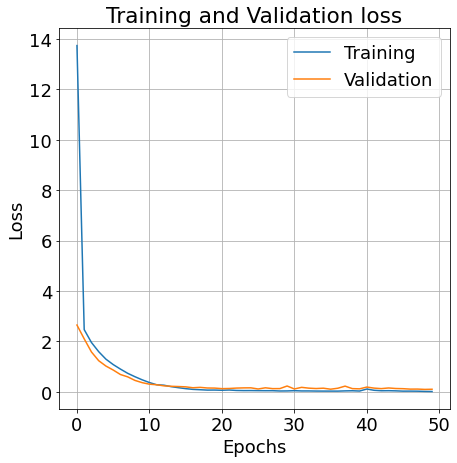

KeyError: 'accuracy'

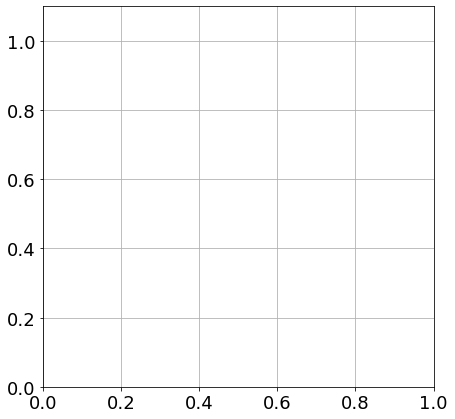

In [9]:
## Loading Dataset
## There is a typo in the paper on page#4 Table#4, the training samples are not 10%, the reported accuracies are obtained with almost 30~40% training samples. 
data_path = os.path.join(os.getcwd(),'C:/Users/MONSTER/Desktop/Projects/A-Fast-and-Compact-3-D-CNN-for-HSIC-master/A-Fast-and-Compact-3-D-CNN-for-HSIC-master/data')
HSI = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
GT = labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
HSI.shape, GT.shape
## Reduce the Dimensionality 
HSI = DL_Method(HSI, numComponents=20)
HSI.shape
## Create Image Cubes for Model Building
HSI, GT = HSICubes(HSI, GT, WinSize=11)
HSI.shape, GT.shape
## Split Train and Test sets
Tr, Te, TrC, TeC = SplitTr_Te(HSI, GT, 0.40)
Tr.shape, Te.shape, TrC.shape, TeC.shape
## Split Train and Validation
Tr, Tv, TrC, TvC = SplitTr_Te(Tr, TrC, 0.30)
Tr.shape, Tv.shape, TrC.shape, TvC.shape
## Model Pre requsites
Tr = Tr.reshape(-1, 11, 11, 20, 1)
TrC = np_utils.to_categorical(TrC)
Tv = Tv.reshape(-1, 11, 11, 20, 1) 
TvC = np_utils.to_categorical(TvC)
Tr.shape, TrC.shape, Tv.shape, TvC.shape
## Model Structure 
## Input layer
input_layer = Input((11, 11, 20, 1))
## 3D Convolutional Layers
conv_layer1 = Conv3D(filters=8, kernel_size=(3, 3, 7), activation='relu')(input_layer)
conv_layer2 = Conv3D(filters=16, kernel_size=(3, 3, 5), activation='relu')(conv_layer1)
conv_layer3 = Conv3D(filters=32, kernel_size=(3, 3, 3), activation='relu')(conv_layer2)
conv_layer4 = Conv3D(filters=64, kernel_size=(3, 3, 3), activation='relu')(conv_layer3)
## Faltten 3D Convolutional Layer
flatten_layer = Flatten()(conv_layer4)
## Fully Connected Layers
dense_layer1 = Dense(units=256, activation='relu')(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=128, activation='relu')(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=16, activation='softmax')(dense_layer2)

# define the model with input layer and output layer
model = Model(inputs=input_layer, outputs=output_layer)
model.summary()
# compiling the model
adam = Adam(lr=0.001, decay=1e-06)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
## Training Time and Fit the Model 
start = time.time()
history = model.fit(x=Tr, y=TrC, batch_size=256, epochs=50, validation_data=(Tv, TvC))
end = time.time()
Tr_Time = end - start
## Plot Training and Validation loss and Accuracy 
plt.figure(figsize=(7,7))
plt.rcParams.update({'font.size': 18})
plt.grid()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.title('Training and Validation loss')
plt.legend(['Training','Validation'], loc='upper right')
plt.savefig("IP_loss.eps")
plt.show()
## Plot Training and Validation Accuracy
plt.figure(figsize=(7,7))
plt.ylim(0,1.1)
plt.grid()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.title('Training and Validation Accuracy')
plt.legend(['Training','Validation'])
plt.savefig("IP_Accuracy.eps")
plt.show()
## Testing Phase
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
## Reshape Test Data
Te = Te.reshape(-1, 11, 11, 20, 1)
TeC = np_utils.to_categorical(TeC)
Te.shape, TeC.shape
## Computing and Writing the Accuacy in .txt file
classification,confusion,Test_loss,Test_accuracy,oa,each_acc,aa,kappa,target_names,y_pred,Time = reports(Te,TeC)
classification = str(classification)
confusion = str(confusion)
print(classification), print(Test_accuracy), print(oa), print(aa), print(Tr_Time), print(Time)
## Draw Confusion Matrix
confusion = confusion_matrix(np.argmax(TeC, axis=1), y_pred, labels=np.unique(np.argmax(TeC, axis=1)))
cm_sum = np.sum(confusion, axis=1, keepdims=True)
cm_perc = confusion / cm_sum.astype(float) * 100
annot = np.empty_like(confusion).astype(str)
nrows, ncols = confusion.shape
for i in range(nrows):
    for j in range(ncols):
        c = confusion[i, j]
        p = cm_perc[i, j]
        if i == j:
            s = cm_sum[i]
            annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
        elif c == 0:
            annot[i, j] = ''
        else:
            annot[i, j] = '%.1f%%\n%d' % (p, c)
cm = pd.DataFrame(confusion, index=np.unique(target_names), columns=np.unique(target_names))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
fig, ax = plt.subplots(figsize=(15,10))
plt.rcParams.update({'font.size': 12})
sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)
## Loading Dataset
data_path = os.path.join(os.getcwd(),'/content/drive/My Drive/Colab')
HSI = sio.loadmat(os.path.join(data_path, 'Indian_pines_corrected.mat'))['indian_pines_corrected']
GT = labels = sio.loadmat(os.path.join(data_path, 'Indian_pines_gt.mat'))['indian_pines_gt']
## Check the Dimensions of HSI
height = GT.shape[0]
width = GT.shape[1]
PATCH_SIZE = 11
## Dimensional Reduction and zero padding
HSI = DL_Method(HSI, numComponents=20)
HSI.shape
HSI = ZeroPad(HSI, 11//2)
## Calculate the predicted Ground Truths
outputs = np.zeros((height,width))
for i in range(height):
    for j in range(width):
        target = int(GT[i,j])
        if target == 0 :
            continue
        else :
            image_patch=Patch(HSI,i,j)
            X_test_image = image_patch.reshape(1,image_patch.shape[0],
                                               image_patch.shape[1], image_patch.shape[2], 1).astype('float32')                                   
            prediction = (model.predict(X_test_image))
            prediction = np.argmax(prediction, axis=1)
            outputs[i][j] = prediction+1
## Show Ground Truths
ground_truth = spectral.imshow(classes = GT,figsize =(7,7))
predict_image = spectral.imshow(classes = outputs.astype(int),figsize =(7,7))
spectral.save_rgb("predictions.png", outputs.astype(int), colors=spectral.spy_colors)
spectral.save_rgb("ground_truth.png", GT, colors=spectral.spy_colors)